In [1]:
# Autoreload 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Lightning #
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.utilities.rank_zero import rank_zero_only # NEW
from datetime import datetime

# Bacis libraries #
import os   
from dotenv import load_dotenv
load_dotenv('/home/pk21271/keys/key.env')
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Pytorch #
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Personal scripts #
path_src = '../src'
if path_src not in sys.path:
    sys.path.insert(0,path_src)
from preprocessing import *
from callbacks import *
from transformer import AnalysisObjectTransformer, Embedding
from losses import *
from plotting import plot_roc, plot_confusion_matrix


torch.set_float32_matmul_precision('medium')
accelerator = 'gpu' if torch.cuda.is_available() else "cpu"
print (f"Accelerator : {accelerator}")


Accelerator : gpu


# Import datasets

Our files are in parquet files : one for each process, containing all the event level information

The following lines do the import into a pandas dataframe, and the different preprocessing steps we need (remove negative weight events, make labls, split into training and validation sets, etc)

In [2]:
# Make output directory #
current_time = datetime.now().strftime("%Y%m%d_%H%M%S")
outdir = f"./model_training/AOTransformer_{current_time}"
os.makedirs(outdir, exist_ok=False)

# Main path
main_path = '/home/pk21271/prep_data/ttH_ttbar_jets'

# File paths
x_path = os.path.join(main_path, 'X.pt')
y_path = os.path.join(main_path, 'y.pt')
pad_mask_path = os.path.join(main_path, 'pad_mask.pt')
reweighting_path = os.path.join(main_path, 'reweighting.pt')
weight_nom_path = os.path.join(main_path, 'weight_nom.pt')
event_level_path = os.path.join(main_path, 'event_level.pt')

# Load data
X = torch.load(x_path)
y = torch.load(y_path)
pad_mask = torch.load(pad_mask_path)
reweighting = torch.load(reweighting_path)
weight_nom = torch.load(weight_nom_path)
event_level = torch.load(event_level_path)

## Create training datasets ## Also added the nominal weights
train_X, val_X, train_y, val_y, train_weights, val_weights, train_mask, val_mask, train_event, val_event, train_nom, val_nom = train_test_split(
    X, 
    y, 
    reweighting, 
    pad_mask, 
    event_level,
    weight_nom, 
    test_size=0.2,  
    random_state=42,
)

train_dataset = TensorDataset(train_X, train_y, train_weights, train_mask, train_event)
valid_dataset = TensorDataset(val_X, val_y, val_weights, val_mask, val_event)

## Create loaders ##
batch_size = 1024

train_loader = DataLoader(
    dataset = train_dataset, 
    batch_size = batch_size, 
    shuffle = True,
    num_workers = 11, 
)
valid_loader = DataLoader(
    dataset = valid_dataset, 
    batch_size = 10000, # can use larger batches for the GPU 
    shuffle = False, 
    num_workers = 11,
)
# NOTE : in a jupyter notebook it is not possible to use `num_workers` dues to multiprocessing issues.
# Use this notebook for testing and experimenting, but to benefit from multiprocessing batch loading, you will need the python scripts

/tmp/ipykernel_2875553/3684652484.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X = torch.load(x_path)
/tmp/ipykernel_2875553/3684652484.py:19: FutureWarning: You are

# Input plots 

Always a good idea to check the inputs you provide in the training. It is very easy to introduce incorrect data in the training, and then spend hours investigating the problem in the model, only to find the data is nonsensical (the good old "garbage in, garbage out" syndrom).

The plotting scripts below show the inputs features (ie, jet features) as a function of the multiplicity and labels.
- var 0 : $p_T$
- var 1 : $\eta$
- var 2 : $\phi$
- var 3 : mass
- var 4 : area


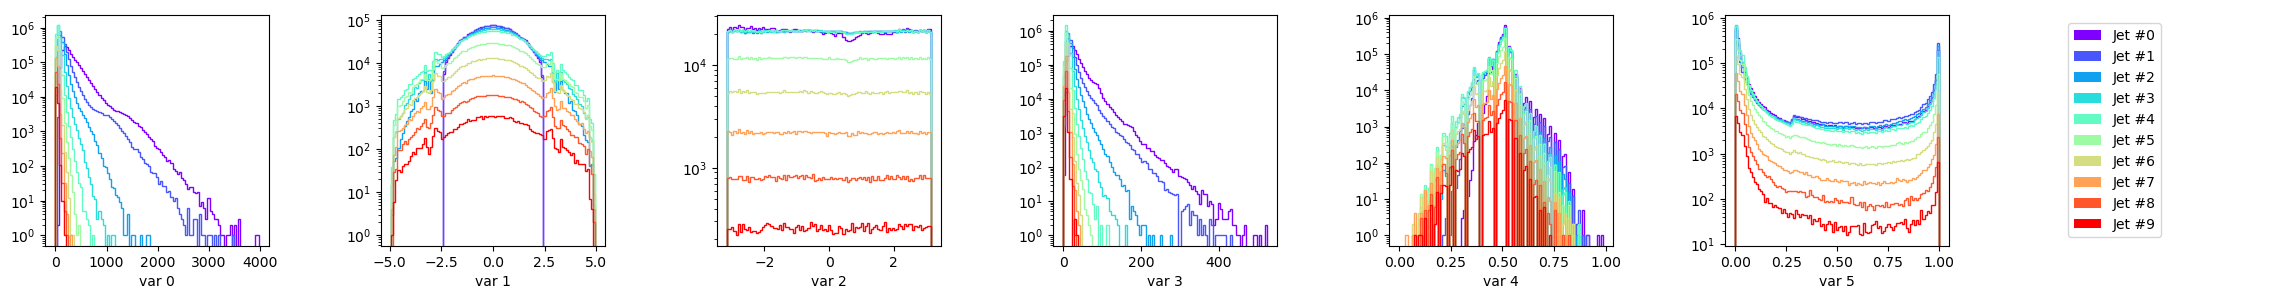

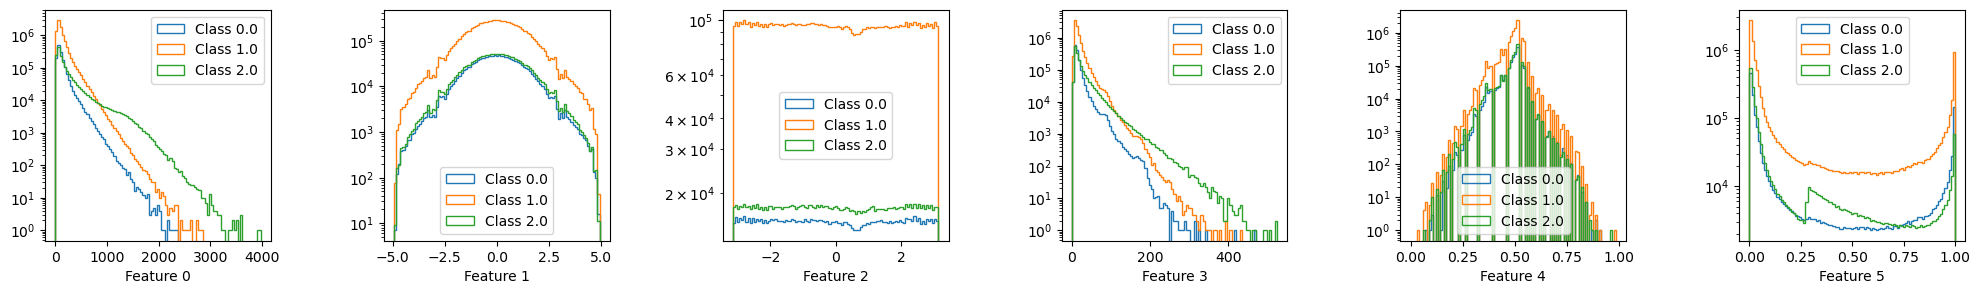

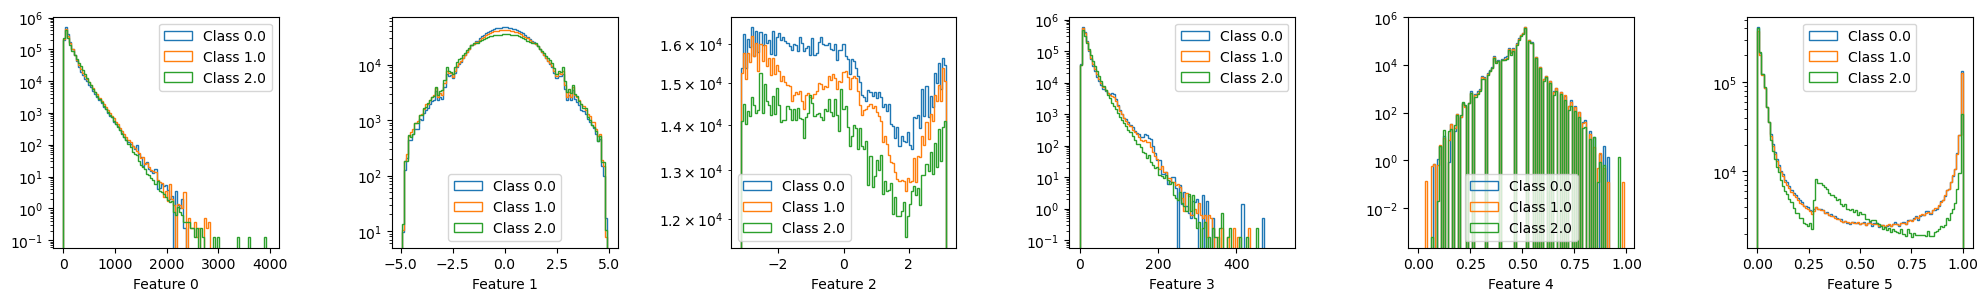

In [3]:
fig = plot_inputs_per_multiplicity(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,log=True,show=True)
fig = plot_inputs_per_label_multi(X,y,pad_mask,bins=100,weights=reweighting,log=True,show=True)

# Model
The transformer model can be tweaked with the parameters below (see explanations for each parameter.

The loss function is a composite of BCE, and decorrelation from the MET, to ensure the transformer does not sculpt the latter.

In [4]:
# Define model #
# loss_function = CrossEntropyWeightedLoss(weighted = True) # Test with no weights,

alpha = 0.25 # This is the weight for the signal class, the rest is divided among the background classes
alpha = [alpha, (1-alpha)/2, (1-alpha)/2]
# alpha = [alpha, (1-alpha)] # For binary classification

# Create an alpha from inverse class frequency weighted

# train_y_flat = train_y.flatten()

# frequencies = np.array([torch.sum(train_nom[train_y_flat == 0]).item(),torch.sum(train_nom[train_y_flat == 1]).item(),torch.sum(train_nom[train_y_flat == 2]).item()])

# inv_frequencies = 1/frequencies

# norm_inv_frequencies = inv_frequencies/np.sum(inv_frequencies)

# alpha = norm_inv_frequencies

print(alpha)

gamma = 2 # 2 is recommended, 0 is equivalent to CE

loss_function = FocalLoss(gamma=0.5, alpha=None, weighted=False) 

# loss = BCE + lambda * decorrelated loss # Lambda determines the strength of the decorrelation loss
# lambda = 0 -> pure BCE

# Embedding of the jet features into a higher dimension
embedding = Embedding(
    input_dim = train_X.shape[-1],   # Input dimension  
    embed_dims = [64],               # Output dimension
    normalize_input = True,          # Whether to apply batch norm before the embedding
)

output_dim = len(torch.unique(y)) if len(torch.unique(y)) > 2 else 1
print(output_dim)

# Choose number of layers
enc = 5
cla = 2
dnn = 3

model = AnalysisObjectTransformer(
    embedding = embedding,           # Embedding instance 
    embed_dim = embedding.dim,       # Embedding dimension
    num_heads = 8,                   # Number of heads for multihead attention (must be a divisor of embed dim) 
    output_dim = output_dim,         # Output dimension (1 : binary classification, >1 : multi classification) 
    expansion_factor = 4,            # Multipliying factor for layers in attention block (neurons = embed_dim * expansion_factor) norm is 4
    encoder_layers = enc,              # Number of encoder layers (self attention on jets)
    class_layers = cla,                # Number of class layers (cross attention between jets representations and class token)
    dnn_layers = dnn,                  # Number of layers for DNN after the transformer
    hidden_activation = nn.GELU,     # Hidden activation in transformer and DNN
    output_activation = None,        # DNN output activation (sigmoid for binary, softmax for multiclass, None if applied in the loss)
    dropout = 0.1,                   # Dropout rate - default was 0.1
    loss_function = loss_function,   # Loss function, see above
)

# Print the model graph #
print (model)
# Quick benchmark test the model #
# To make sure the model will run, we take a single batch from the training and pass it through the model

batch = next(iter(train_loader))

inputs, labels, weights, mask, event = batch
print ('Batch dtypes',inputs.dtype,labels.dtype,weights.dtype,mask.dtype,event.dtype)

outputs = model(inputs,padding_mask=mask)
print ('outputs',outputs .shape)
loss_values = loss_function(outputs,labels,event,weights)
print ('losses',loss_values)

[0.25, 0.375, 0.375]
3
AnalysisObjectTransformer(
  (embedding): Embedding(
    (input_bn): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layers): Sequential(
      (0): Linear(in_features=6, out_features=64, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (encoder_blocks): ModuleList(
    (0-4): 5 x AttBlock(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multihead_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (layer_norm3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (linear1): Linear(in_features=64, out_features=256, bias=True)
      (activation): GELU(approximate='none')
      (layer_norm4): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (linear2): Linear(in_features=256, out_features=64, bias=True)
    )


# Training 

Writing the training loop can involve a biut of boilerplate code. To bypass that we use the [pytorch-lightning](https://lightning.ai/docs/pytorch/stable/) package to run the training. 

The batch steps were defined in the model class, and now we can use the trainer class from lightning to run the training. This takes care of doing the loop, putting data on the GPU if needed, applying the schedule, etc.

One way to finetune our training (or monitor it) is through callbacks. Callbacks are class objects that are evaluated at different times during the training, and allow the user to access their model. Below we use a few of those :
- model checkpoint : saves the best model parameters at every epoch
- early stopping : if the loss values (of the validation) plateau, stops the training (hopefully before overtraining)
- plotting : a plotting callback we wrote to plot the classification metrics at every epoch
- a few other tweaks

Lighting also allows several plotter interface, we use `comet` to log all our metrics (and callback plots) online. You will need an account [here](https://www.comet.com/signup), you can use your github account if you want.

In [5]:
##### Parameters #####

# Choose max epochs and learning rate
epochs = 150
# lr = 1e-4 # Probs use this 
# lr = 5e-4
lr = 1e-3 # This lr is too high for 128, 8,2,3


print(len(train_dataset), len(valid_dataset))

steps_per_epoch_train = math.ceil(len(train_dataset)/train_loader.batch_size)
steps_per_epoch_valid = math.ceil(len(valid_dataset)/valid_loader.batch_size)

print (f'Training   : Batch size = {train_loader.batch_size} => {steps_per_epoch_train} steps per epoch')
print (f'Validation : Batch size = {valid_loader.batch_size} => {steps_per_epoch_valid} steps per epoch')

# Setup optimizer #
optimizer = optim.Adam(model.parameters(), lr=lr)
model.set_optimizer(optimizer)

# Setup scheduler #
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
   optimizer = optimizer,
   mode = 'min', 
   factor = 0.2, 
   patience = 4, #Was 10
   threshold = 0., 
   threshold_mode = 'rel', 
   cooldown = 0, 
   min_lr = 1e-8,
)

model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'lr',
    }
)

# Setup callbacks #
checkpoint_callback = ModelCheckpoint(
    dirpath=outdir,  # Directory where checkpoints will be saved
    filename="best-checkpoint",  # Checkpoint filename
    monitor="val/loss_tot",  # Monitor validation loss
    mode="min",  # Save the best model with the minimum validation loss
    save_top_k=1  # Save only the best model
)

early_stopping = EarlyStopping(
    monitor='val/loss_tot',  # Metric to monitor
    patience=10,          # Number of epochs with no improvement after which training will be stopped #Defacult was 30, changed to 8
    verbose=True,
    mode='min'           # 'min' for loss, 'max' for accuracy
)

log_bar = L.pytorch.callbacks.TQDMProgressBar(refresh_rate=steps_per_epoch_train//100)

plots_callback = EpochEndCallback(
    data = valid_loader,
    frequency = 1,
    subcallbacks = [
        ScoreSubCallback(name='score',bins=100,log=True),
        CorrelationSubCallback(name='corr',bins=100,log=True),
        ROCSubCallback(name='ROC'),
        ConfusionMatrixSubCallback(name='CM'),
    ]
)

## Logger ##
# logger = CometLogger(
#     api_key = os.environ.get("COMET_API_KEY"), 
#     project_name = "AnalysisObjectTransformer",
#     experiment_name = "Setup",
#     save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
#     offline = False  # Set to True for offline mode


## Logger ## (THIS IS THE NEW ONE WITH THE PATH SETUP)
logger = CometLogger(
    api_key = os.getenv("COMET_API_KEY"),
    project_name = "AnalysisObjectTransformer",
    experiment_name = f"Mult {enc},{cla},{dnn} | lr={lr}",
    save_dir = "./comet_logs",  # Specify where to save Comet logs if offline
    offline = False  # Set to True for offline mode
)

## Trainer ##
trainer = L.Trainer(
    strategy = "ddp_notebook",
    default_root_dir = outdir,
    accelerator = accelerator,
    devices = [0,1,2,3,4,5],  # Use only one GPU
    max_epochs = epochs,  # Specify the number of epochs
    log_every_n_steps = steps_per_epoch_train, # This is logging the wrong number
    check_val_every_n_epoch = 1,  # Check validation every n epochs
    callbacks = [  # Remove the plotting callbacks 
        early_stopping,
        log_bar,
    ],
    logger = logger,
    # limit_train_batches = 10,
    # limit_val_batches = 1,
    # limit_test_batches = 1,
)

trainer.fit(
    model = model, 
    train_dataloaders = train_loader, 
    val_dataloaders = valid_loader,
)
trainer.save_checkpoint(f"{outdir}/model.pt")

1701001 425251
Training   : Batch size = 1024 => 1662 steps per epoch
Validation : Batch size = 10000 => 43 steps per epoch


CometLogger will be initialized in online mode
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/6
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/6
Initializing distributed: GLOBAL_RANK: 2, MEMBER: 3/6
Initializing distributed: GLOBAL_RANK: 4, MEMBER: 5/6
Initializing distributed: GLOBAL_RANK: 3, MEMBER: 4/6
Initializing distributed: GLOBAL_RANK: 5, MEMBER: 6/6
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 6 processes
----------------------------------------------------------------------------------------------------

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/software/pk21271/miniconda3/envs/hinv-ml/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (277) is smaller than the logging interval Trainer(log_every_n_steps=1662). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved. New best score: 0.442
[rank: 2] Metric val/loss_tot improved. New best score: 0.442
[rank: 1] Metric val/loss_tot improved. New best score: 0.442
[rank: 4] Metric val/loss_tot improved. New best score: 0.442
[rank: 3] Metric val/loss_tot improved. New best score: 0.442
[rank: 5] Metric val/loss_tot improved. New best score: 0.442


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407
[rank: 2] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407
[rank: 3] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407
[rank: 5] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407
[rank: 1] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407
[rank: 4] Metric val/loss_tot improved by 0.035 >= min_delta = 0.0. New best score: 0.407


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390
[rank: 2] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390
[rank: 4] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390
[rank: 5] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390
[rank: 3] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390
[rank: 1] Metric val/loss_tot improved by 0.017 >= min_delta = 0.0. New best score: 0.390


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377
[rank: 2] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377
[rank: 1] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377
[rank: 4] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377
[rank: 5] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377
[rank: 3] Metric val/loss_tot improved by 0.013 >= min_delta = 0.0. New best score: 0.377


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371
[rank: 1] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371
[rank: 3] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371
[rank: 5] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371
[rank: 2] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371
[rank: 4] Metric val/loss_tot improved by 0.005 >= min_delta = 0.0. New best score: 0.371


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365
[rank: 2] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365
[rank: 1] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365
[rank: 5] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365
[rank: 3] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365
[rank: 4] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.365


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362
[rank: 4] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362
[rank: 5] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.362


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354
[rank: 1] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354
[rank: 5] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354
[rank: 2] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354
[rank: 4] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354
[rank: 3] Metric val/loss_tot improved by 0.008 >= min_delta = 0.0. New best score: 0.354


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352
[rank: 5] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352
[rank: 4] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352
[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.352


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348
[rank: 2] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348
[rank: 5] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348
[rank: 3] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348
[rank: 1] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348
[rank: 4] Metric val/loss_tot improved by 0.003 >= min_delta = 0.0. New best score: 0.348


Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346
[rank: 2] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346
[rank: 5] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346
[rank: 3] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346
[rank: 4] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346
[rank: 1] Metric val/loss_tot improved by 0.002 >= min_delta = 0.0. New best score: 0.346


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339
[rank: 1] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339
[rank: 4] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339
[rank: 2] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339
[rank: 5] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339
[rank: 3] Metric val/loss_tot improved by 0.007 >= min_delta = 0.0. New best score: 0.339


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[rank: 0] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
[rank: 5] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
[rank: 4] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
[rank: 2] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
[rank: 3] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
[rank: 1] Monitored metric val/loss_tot did not improve in the last 10 records. Best score: 0.339. Signaling Trainer to stop.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COME

In [6]:
## Testing model performance on validation set ##
single_gpu_trainer = L.Trainer(accelerator="gpu", devices=1)
preds = single_gpu_trainer.predict(model=model, dataloaders=valid_loader)
preds = torch.cat(preds, dim=0)

inputs, labels, weights, mask, event = valid_dataset.tensors

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5]


Predicting: |          | 0/? [00:00<?, ?it/s]

# Metrics

In [7]:
probs = torch.softmax(preds, dim=1)  # Converts logits to probabilities
predicted_classes = np.argmax(probs, axis=1)
wn = np.array((val_nom * 200000).flatten()) # Multiply by 200,000 to get the original weights

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

num_classes = len(np.unique(labels))
class_labels = ["ttH", "ttBar", "V+jets"][:num_classes]
print(num_classes)

print(classification_report(labels, predicted_classes, target_names=class_labels, sample_weight=wn)) 

3
              precision    recall  f1-score   support

         ttH       0.18      0.29      0.22 651.496844597481
       ttBar       0.90      0.94      0.92 33376.15601280637
      V+jets       0.71      0.49      0.58 6801.241625032779

    accuracy                           0.86 40828.89448243663
   macro avg       0.60      0.57      0.57 40828.89448243663
weighted avg       0.85      0.86      0.85 40828.89448243663



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrices first (avoid multiple calls to .plot())
cm_true = confusion_matrix(labels, predicted_classes, normalize="true", sample_weight=wn)
cm_pred = confusion_matrix(labels, predicted_classes, normalize="pred", sample_weight=wn)

# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot "True" normalized confusion matrix on the first axis
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
axes[0].set_title("Normalized by True Labels")

# Plot "Pred" normalized confusion matrix on the second axis
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
axes[1].set_title("Normalized by Predicted Labels")

# Adjust layout and show
plt.tight_layout()
plt.show()

SyntaxError: invalid syntax (721564809.py, line 22)

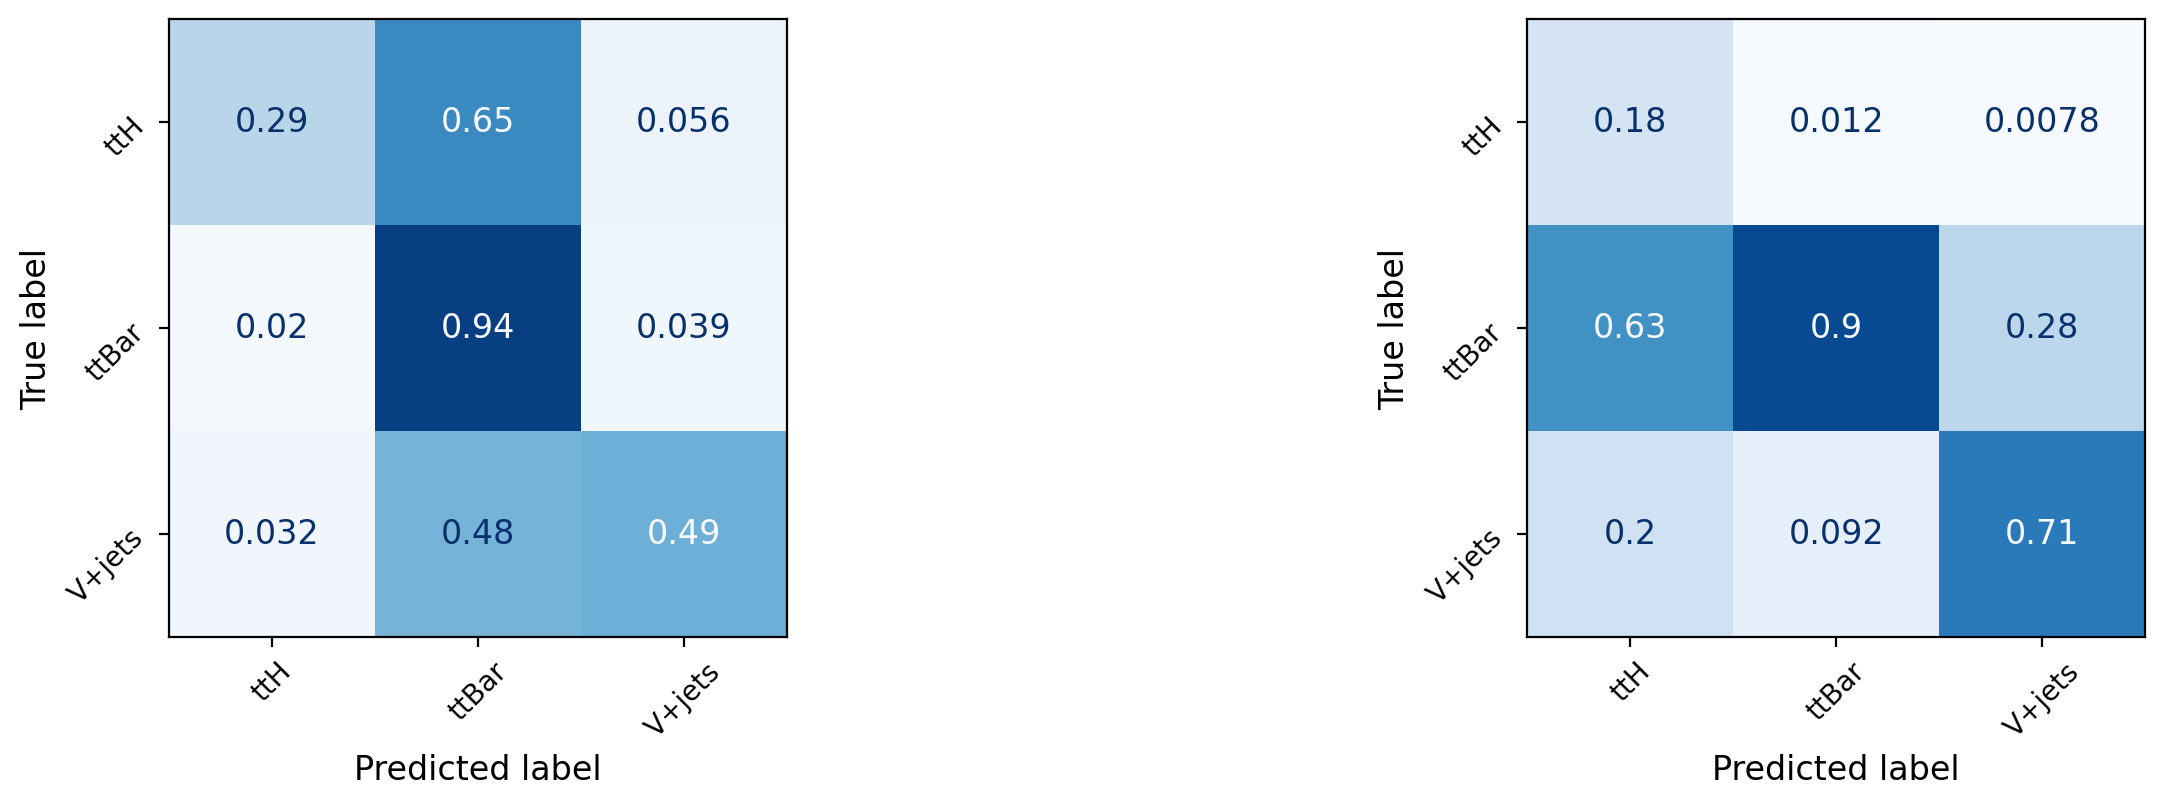

In [27]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set global font sizes
plt.rcParams.update({
    'font.size': 26,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# Compute confusion matrices
cm_true = confusion_matrix(labels, predicted_classes, normalize="true", sample_weight=wn)
cm_pred = confusion_matrix(labels, predicted_classes, normalize="pred", sample_weight=wn)

# Create larger figure
fig, axes = plt.subplots(1, 2, figsize=(15, 6), dpi = 200)

# Plot "True" normalized confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_true, display_labels=class_labels)
disp1.plot(ax=axes[0], cmap=plt.cm.Blues, colorbar=False)
# axes[0].set_title("Normalized by True Labels", pad=20, fontsize=16)
axes[0].tick_params(labelrotation=45)

# Plot "Pred" normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=class_labels)
disp2.plot(ax=axes[1], cmap=plt.cm.Blues, colorbar=False)
# axes[1].set_title("Normalized by Predicted Labels", pad=20, fontsize=16)
axes[1].tick_params(labelrotation=45)

# Add text annotations with larger font
for ax in axes:
    for im in ax.get_images():
        # Increase font size of cell values
        im.set_clim(0, 1)  # Set color scale
        texts = ax.texts
        for text in texts:
            text.set_fontsize(12)

# Adjust layout with more space
plt.tight_layout(pad=3.0)
plt.show()

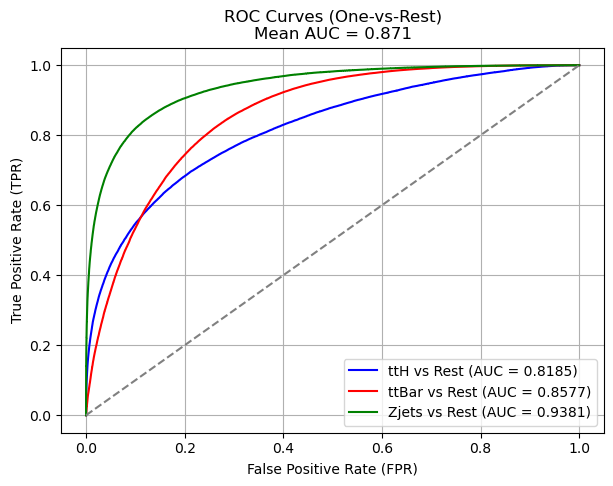

In [10]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

# Initialize storage for AUC scores
auc_scores = []

# Plot ROC curves for all classes
plt.figure(figsize=(7, 5))
# classes = ['ttH', 'ttBar', 'Zjets', 'Wjets']
# colors = ['blue', 'red', 'green', 'orange']
classes = ['ttH', 'ttBar', 'Zjets']
colors = ['blue', 'red', 'green']

for i, (class_name, color) in enumerate(zip(classes, colors)):
    # Convert labels to binary (current class = 1, others = 0)
    binary_labels = (labels == i).to(torch.int)
    class_probs = probs[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(binary_labels, class_probs)
    auc_score = roc_auc_score(binary_labels, class_probs)
    auc_scores.append(auc_score)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color, 
             label=f"{class_name} vs Rest (AUC = {auc_score:.4f})")

mean_auc = np.mean(auc_scores)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title(f"ROC Curves (One-vs-Rest)\nMean AUC = {mean_auc:.3f}")
plt.legend()
plt.grid()
plt.show()

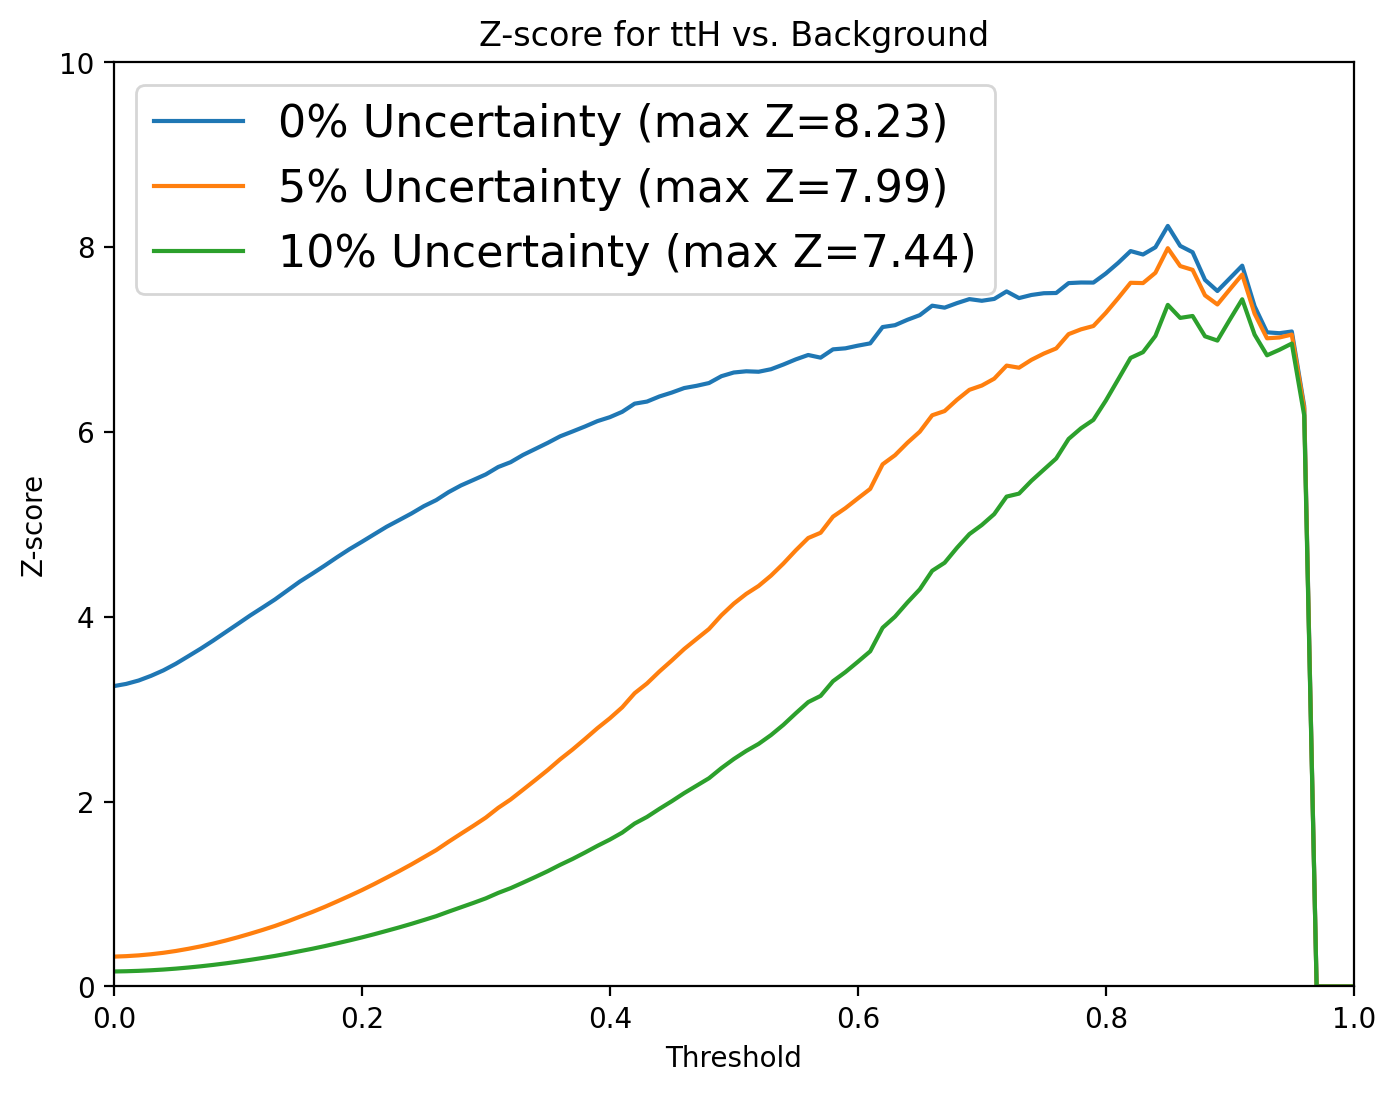

In [19]:
# Weights array
wn = np.array((val_nom * 200000).flatten())  # Weight nominal

probs_flat = np.array(probs[:, 0].flatten())  # Take softmax output for ttH

# Convert labels: ttH (0) → 1 (signal), Others (1,2) → 0 (background)
binary_labels = np.where(labels == 0, 1, 0).flatten()

# Define threshold range
thresholds = np.linspace(0, 1, 101)

# Define systematic uncertainty levels
error_levels = [0.0, 0.05, 0.10]  # 0%, 5%, 10%
z_scores_dict = {err: [] for err in error_levels}
max_z_thresholds = {}  # Dictionary to store max Z-score and its threshold

# Compute Z-score at different thresholds
for threshold in thresholds:
    # Weighted Signal (S): Sum of weights where ttH is predicted above threshold
    mask_signal = (probs_flat > threshold) & (binary_labels == 1)
    mask_background = (probs_flat > threshold) & (binary_labels == 0)

    S = np.sum(wn[mask_signal])  # True ttH predictions
    B = np.sum(wn[mask_background])  # Background events

    for err in error_levels:
        sig_B = B * err  # Apply systematic uncertainty
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)  # Avoid division by zero

        # If B or S is less than 3, set Z to 0
        if B < 3 or S < 3:
            Z = 0

        z_scores_dict[err].append(Z)

# Find the threshold corresponding to max Z-score for each error level
legend_labels = []
for err, z_scores in z_scores_dict.items():
    max_z_index = np.argmax(z_scores)  # Get index of max Z-score
    max_z = z_scores[max_z_index]
    max_threshold = thresholds[max_z_index]
    max_z_thresholds[err] = (max_z, max_threshold)

    # print(f"Max Z-score for error {int(err*100)}%: {max_z:.3f} at threshold {max_threshold:.3f}")
    
    # Store formatted legend label
    # legend_labels.append(f"Error {int(err*100)}% (max Z
    legend_labels.append(f"{int(err*100)}% Uncertainty (max Z={max(z_scores):.2f})")
    # legend_labels.append(f"{int(err*100)}% Uncertainty")



# Plot Z-score vs. Threshold for different systematic uncertainties
plt.figure(figsize=(8, 6), dpi=200)
for (err, z_scores), label in zip(z_scores_dict.items(), legend_labels):
    plt.plot(thresholds, z_scores, label=label)

plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score for ttH vs. Background")
plt.ylim(0, max(max_z_thresholds[err][0] for err in error_levels) + 3)
plt.ylim(0, 10)
plt.xlim(0, 1)
plt.legend(fontsize=16) # increase legend font siz

plt.show()


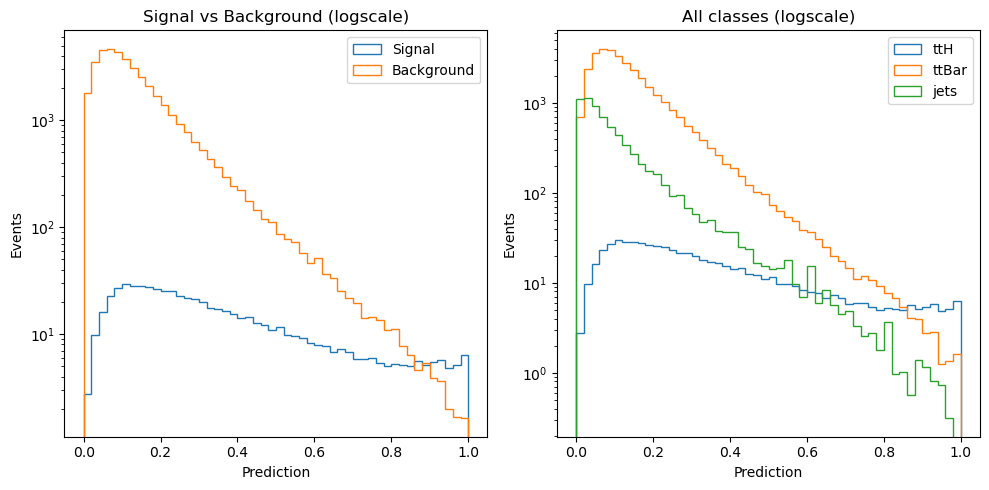

In [12]:
labels_flat = labels.flatten()

# Create a figure with two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)

# First plot (Binary classification: Signal vs. Background)
# axes[0].hist(probs_flat[binary_labels == 1], bins=100, range=(0, 1), weights=wn[binary_labels == 1], histtype='step', label='Signal', density=True)
# axes[0].hist(probs_flat[binary_labels == 0], bins=100, range=(0, 1), weights=wn[binary_labels == 0], histtype='step', label='Background', density=True)
axes[0].hist(probs_flat[binary_labels == 1], bins=50, range=(0, 1), weights=wn[binary_labels == 1], histtype='step', label='Signal')
axes[0].hist(probs_flat[binary_labels == 0], bins=50, range=(0, 1), weights=wn[binary_labels == 0], histtype='step', label='Background')
axes[0].legend()
axes[0].set_ylabel('Events')
axes[0].set_xlabel('Prediction')
axes[0].set_yscale('log')
axes[0].set_title('Signal vs Background (logscale)')

# Second plot (Multi-class: ttH, ttBar, Zjets)
axes[1].hist(probs_flat[labels_flat == 0], bins=50, range=(0, 1), weights=wn[labels_flat == 0], histtype='step', label='ttH')
axes[1].hist(probs_flat[labels_flat == 1], bins=50, range=(0, 1), weights=wn[labels_flat == 1], histtype='step', label='ttBar')
axes[1].hist(probs_flat[labels_flat == 2], bins=50, range=(0, 1), weights=wn[labels_flat == 2], histtype='step', label='jets')
# axes[1].hist(probs_flat[labels_flat == 3], bins=100, range=(0, 1), weights=wn[labels_flat == 3], histtype='step', label='jets')
# axes[1].hist(probs_flat[labels_flat == 4], bins=50, range=(0, 1), weights=wn[labels_flat == 4], histtype='step', label='Multi')

axes[1].legend()
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Events')
axes[1].set_title('All classes (logscale)')
axes[1].set_yscale('log')

# Show the figure
plt.tight_layout()
plt.show()

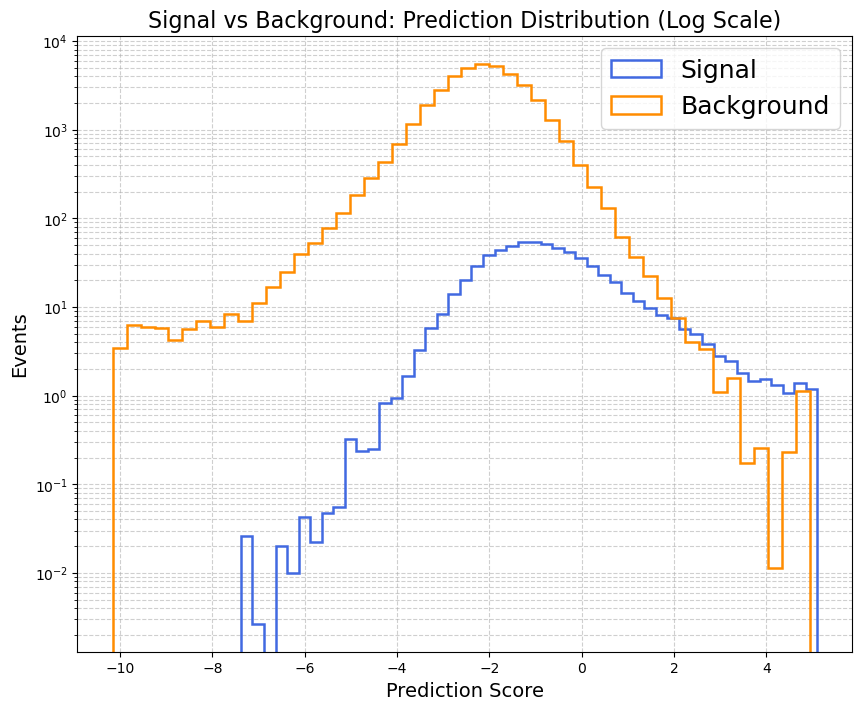

In [13]:
# Plot distribution of new preds

new_preds = np.log(probs_flat/(1-probs_flat))

# Create high-resolution figure
fig, ax = plt.subplots(figsize=(10, 8))  # High DPI for better resolution

# Plot Signal
ax.hist(new_preds[binary_labels == 1], bins=50, 
        weights=wn[binary_labels == 1], histtype='step', 
        label='Signal', linewidth=1.8, color='royalblue')

# Plot Background
ax.hist(new_preds[binary_labels == 0], bins=50, 
        weights=wn[binary_labels == 0], histtype='step', 
        label='Background', linewidth=1.8, color='darkorange')

# Improve labels and title
ax.legend(fontsize=18)
ax.set_ylabel('Events', fontsize=14)
ax.set_xlabel('Prediction Score', fontsize=14)
ax.set_yscale('log')
ax.set_title('Signal vs Background: Prediction Distribution (Log Scale)', fontsize=16)

# Improve grid visibility
ax.grid(True, which="both", linestyle="--", alpha=0.6)

# Show the high-resolution plot
plt.show()


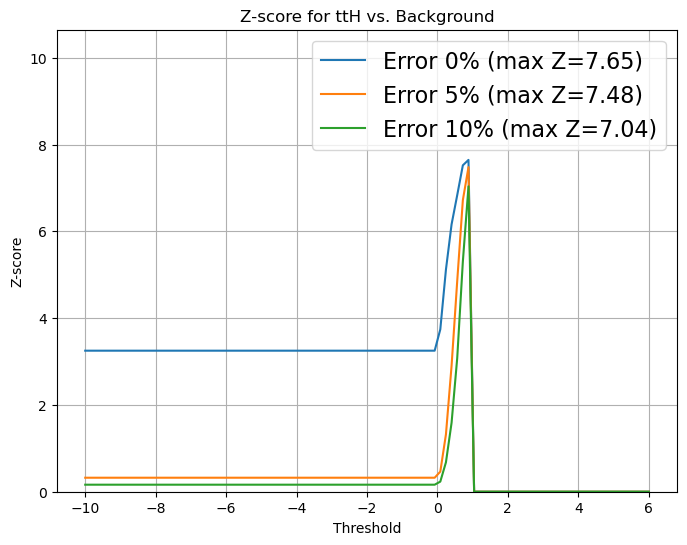

In [14]:
# Weights array
wn = np.array((val_nom * 200000).flatten())  # Weight nominal

probs_flat = np.array(probs[:, 0].flatten())  # Take softmax output for ttH

# Convert labels: ttH (0) → 1 (signal), Others (1,2) → 0 (background)
binary_labels = np.where(labels == 0, 1, 0).flatten()

# Define threshold range
thresholds = np.linspace(-10, 6, 101)

# Define systematic uncertainty levels
error_levels = [0.0, 0.05, 0.10]  # 0%, 5%, 10%
z_scores_dict = {err: [] for err in error_levels}
max_z_thresholds = {}  # Dictionary to store max Z-score and its threshold

# Compute Z-score at different thresholds
for threshold in thresholds:
    # Weighted Signal (S): Sum of weights where ttH is predicted above threshold
    mask_signal = (probs_flat > threshold) & (binary_labels == 1)
    mask_background = (probs_flat > threshold) & (binary_labels == 0)

    S = np.sum(wn[mask_signal])  # True ttH predictions
    B = np.sum(wn[mask_background])  # Background events

    for err in error_levels:
        sig_B = B * err  # Apply systematic uncertainty
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)  # Avoid division by zero

        # If B or S is less than 3, set Z to 0
        if B < 3 or S < 3:
            Z = 0

        z_scores_dict[err].append(Z)

# Find the threshold corresponding to max Z-score for each error level
legend_labels = []
for err, z_scores in z_scores_dict.items():
    max_z_index = np.argmax(z_scores)  # Get index of max Z-score
    max_z = z_scores[max_z_index]
    max_threshold = thresholds[max_z_index]
    max_z_thresholds[err] = (max_z, max_threshold)

    # print(f"Max Z-score for error {int(err*100)}%: {max_z:.3f} at threshold {max_threshold:.3f}")
    
    # Store formatted legend label
    # legend_labels.append(f"Error {int(err*100)}% (max Z
    legend_labels.append(f"Error {int(err*100)}% (max Z={max(z_scores):.2f})")


# Plot Z-score vs. Threshold for different systematic uncertainties
plt.figure(figsize=(8, 6))
for (err, z_scores), label in zip(z_scores_dict.items(), legend_labels):
    plt.plot(thresholds, z_scores, label=label)

plt.xlabel("Threshold")
plt.ylabel("Z-score")
plt.title(f"Z-score for ttH vs. Background")
plt.grid()
plt.ylim(0, max(max_z_thresholds[err][0] for err in error_levels) + 3)
# plt.ylim(0, 10)
# plt.xlim(0, 1)
plt.legend(fontsize=16) # increase legend font siz

plt.show()


# For poster

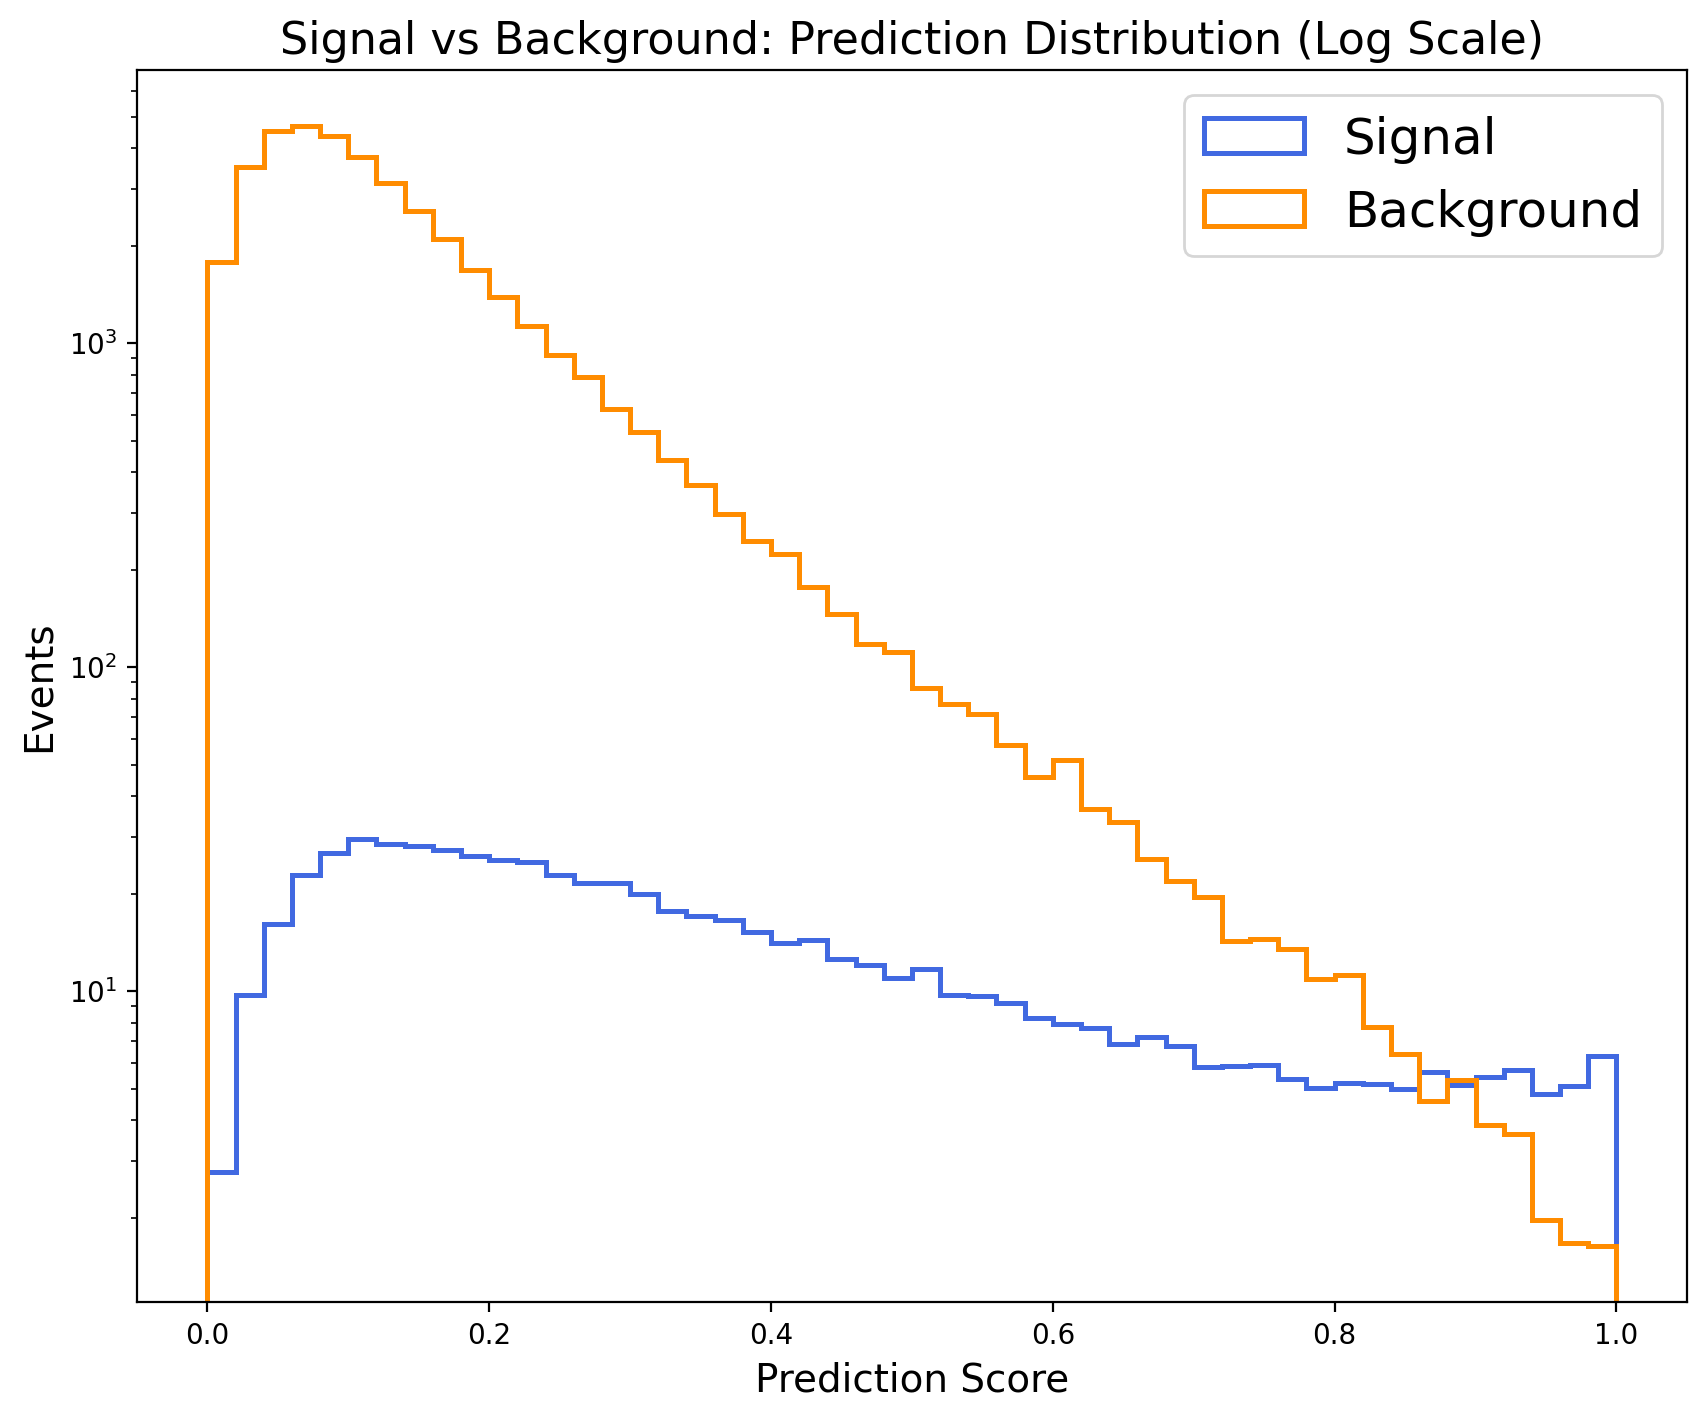

In [15]:
import matplotlib.pyplot as plt

# Create high-resolution figure
fig, ax = plt.subplots(figsize=(10, 8), dpi=200)  # High DPI for better resolution

# Plot Signal
ax.hist(probs_flat[binary_labels == 1], bins=50, range=(0, 1), 
        weights=wn[binary_labels == 1], histtype='step', 
        label='Signal', linewidth=1.8, color='royalblue')

# Plot Background
ax.hist(probs_flat[binary_labels == 0], bins=50, range=(0, 1), 
        weights=wn[binary_labels == 0], histtype='step', 
        label='Background', linewidth=1.8, color='darkorange')

# Improve labels and title
ax.legend(fontsize=18)
ax.set_ylabel('Events', fontsize=14)
ax.set_xlabel('Prediction Score', fontsize=14)
ax.set_yscale('log')
ax.set_title('Signal vs Background: Prediction Distribution (Log Scale)', fontsize=16)

# Improve grid visibility
# ax.grid(True, which="both", linestyle="--", alpha=0.6)

# Show the high-resolution plot
plt.show()


# Discriminant plot from ATLAS paper

In [16]:
dhh_ttH = np.log(probs[:, 0] / (probs[:, 1] + probs[:, 2] + probs[:, 3])) # This find the ln( P(sig) / P(bkg) )
# dhh_ttBar = np.log(probs[:, 1] / (probs[:, 0] + probs[:, 2] + probs[:, 3]))
# dhh_Zjets = np.log(probs[:, 2] / (probs[:, 0] + probs[:, 1] + probs[:, 3]))
# dhh_Wjets = np.log(probs[:, 3] / (probs[:, 0] + probs[:, 1] + probs[:, 2]))

IndexError: index 3 is out of bounds for dimension 1 with size 3

In [ ]:
# plt.hist(dhh_ttH, bins=100, range=(-5, 5), histtype='step', label='ttH')
# plt.hist(dhh_ttBar, bins=100, range=(-5, 5), histtype='step', label='ttBar')
# plt.hist(dhh_Zjets, bins=100, range=(-5, 5), histtype='step', label='Zjets')
# plt.hist(dhh_Wjets, bins=100, range=(-5, 5), histtype='step', label='Wjets')
# plt.title('DHH')
# plt.legend()
# plt.show()

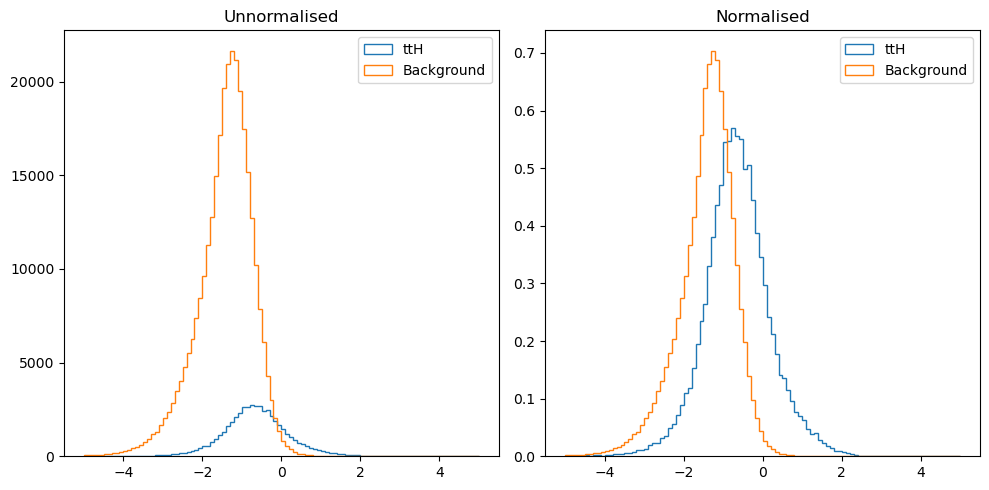

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex=True)


axes[0].hist(dhh_ttH[labels_flat == 0], bins=100, range=(-5, 5), histtype='step', label='ttH', density=False)
axes[0].hist(dhh_ttH[labels_flat == 1], bins=100, range=(-5, 5), histtype='step', label='Background', density=False)
axes[0].legend()
axes[0].set_title('Unnormalised')

axes[1].hist(dhh_ttH[labels_flat == 0], bins=100, range=(-5, 5), histtype='step', label='ttH', density=True)
axes[1].hist(dhh_ttH[labels_flat == 1], bins=100, range=(-5, 5), histtype='step', label='Background', density=True)
axes[1].legend()
axes[1].set_title('Normalised')

plt.tight_layout()
plt.show()


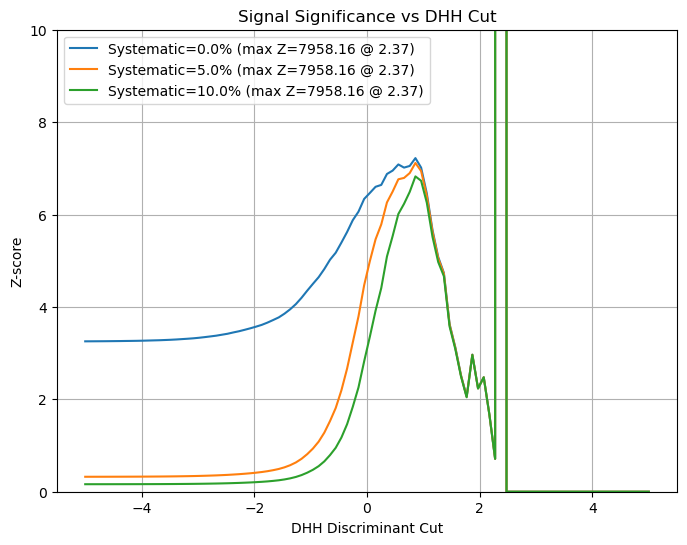

In [ ]:
# Convert tensors
labels_np = labels.cpu().numpy().flatten()
probs_np = probs.cpu().numpy()

dhh = np.log(probs_np[:, 0] / (probs_np[:, 1] + probs_np[:, 2] + probs_np[:, 3]))

# Calculate Z-score for DHH with weights
thresholds = np.linspace(-5, 5, 100)  # DHH range
error_levels = [0.0, 0.05, 0.10]  # 0%, 5%, 10% systematics
z_scores_dict = {err: [] for err in error_levels}

# Signal and background masks
signal_mask = (labels_flat == 0)
bkg_mask = ~signal_mask

# Calculate Z-scores for different systematics
for thresh in thresholds:
    # Get weighted events passing threshold
    S = np.sum(wn[signal_mask & (dhh_ttH > thresh)])
    B = np.sum(wn[bkg_mask & (dhh_ttH > thresh)])
    
    for err in error_levels:
        sig_B = B * err
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)
        z_scores_dict[err].append(Z)

# Plot results
plt.figure(figsize=(8, 6))
for err, z_scores in z_scores_dict.items():
    max_z = max(z_scores)
    max_thresh = thresholds[np.argmax(z_scores)]
    plt.plot(thresholds, z_scores, 
             label=f'Systematic={err*100}% (max Z={max_z:.2f} @ {max_thresh:.2f})')

plt.xlabel('DHH Discriminant Cut')
plt.ylabel('Z-score')
plt.title('Signal Significance vs DHH Cut')
plt.grid(True)
plt.legend()
plt.ylim(0,10)
plt.show()

In [ ]:
# # Now create a ROC curve for the DHH variable

# from sklearn.metrics import roc_curve, auc

# binary_labels_np = np.where(labels_np == 0, 1, 0).flatten()

# # Calculate ROC curve
# fpr, tpr, thresholds = roc_curve(binary_labels_np, dhh)
# roc_auc = auc(fpr, tpr)

# # Create plot
# plt.figure(figsize=(8, 8))
# plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal reference line

# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.grid(True)
# plt.show()

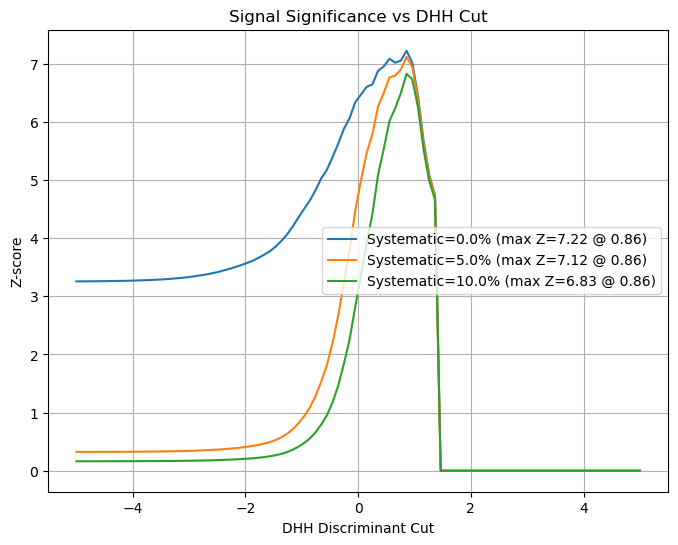

In [ ]:
# Calculate Z-score for DHH with weights
thresholds = np.linspace(-5, 5, 100)  # DHH range
error_levels = [0.0, 0.05, 0.10]  # 0%, 5%, 10% systematics
z_scores_dict = {err: [] for err in error_levels}

# Signal and background masks
signal_mask = (labels_flat == 0)
bkg_mask = ~signal_mask

# Calculate Z-scores for different systematics
for thresh in thresholds:
    # Get weighted events passing threshold
    S = np.sum(wn[signal_mask & (dhh_ttH > thresh)])
    B = np.sum(wn[bkg_mask & (dhh_ttH > thresh)])
    
    for err in error_levels:
        sig_B = B * err
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)

        # If B or S is less than 3, set Z to 0
        if B < 3 or S < 3:
            Z = 0

        z_scores_dict[err].append(Z)

# Plot results
plt.figure(figsize=(8, 6))
for err, z_scores in z_scores_dict.items():
    max_z = max(z_scores)
    max_thresh = thresholds[np.argmax(z_scores)]
    plt.plot(thresholds, z_scores, 
             label=f'Systematic={err*100}% (max Z={max_z:.2f} @ {max_thresh:.2f})')

plt.xlabel('DHH Discriminant Cut')
plt.ylabel('Z-score')
plt.title('Signal Significance vs DHH Cut')
plt.grid(True)
plt.legend()
plt.show()

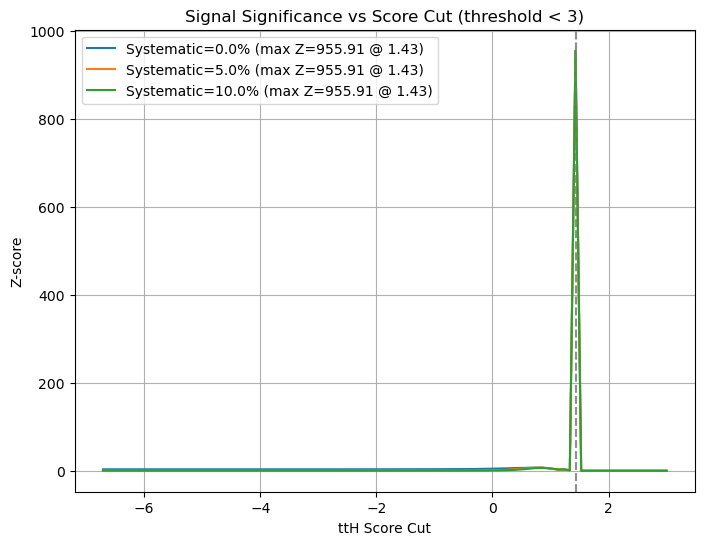

In [ ]:
# Filter thresholds and calculate Z-scores

preds_ttH = preds[:, 0]

thresholds = np.linspace(preds_ttH.min(), 3, 100)  # Upper limit of 3
error_levels = [0.0, 0.05, 0.10]
z_scores_dict = {err: [] for err in error_levels}

# Calculate Z-scores
for thresh in thresholds:
    mask_pass = (preds_ttH > thresh)
    S = np.sum(wn[signal_mask & mask_pass])
    B = np.sum(wn[bkg_mask & mask_pass])
    
    for err in error_levels:
        sig_B = B * err
        Z = S / np.sqrt(B + sig_B**2 + 1e-10)
        z_scores_dict[err].append(Z)

# Plot results
plt.figure(figsize=(8, 6))
for err, z_scores in z_scores_dict.items():
    max_z = max(z_scores)
    max_thresh = thresholds[np.argmax(z_scores)]
    plt.plot(thresholds, z_scores, 
             label=f'Systematic={err*100}% (max Z={max_z:.2f} @ {max_thresh:.2f})')
    # Add vertical line at maximum
    plt.axvline(x=max_thresh, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('ttH Score Cut')
plt.ylabel('Z-score')
plt.title('Signal Significance vs Score Cut (threshold < 3)')
plt.grid(True)
plt.legend()
plt.show()

# Looking at class imbalance with respect to weights

In [ ]:
# Print the weight of ttH / weight of ttBar

# Calculate the weight of ttH / weight of ttBar
weights_ttH = wn[labels_flat == 0]
weights_ttBar = wn[labels_flat == 1]

# Calculate the ratio

ratio = np.sum(weights_ttH) / np.sum(weights_ttBar)
print(ratio)
print(sum(y == 0))

0.023578387
tensor([242882])


In [ ]:
ttH_count = sum(y == 0)
ttbar_count = sum(y == 1)

ratio = ttbar_count / ttH_count

In [ ]:
ratio

tensor([5.5007])